## Getting latent representation from the image

Here we are trying to solve the problem of getting the representation in the latent space from the generated image by the generator. Basically, move back from the original space `x` to the latent space `z`.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Define Generator

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer with tanh applied. We normalize the images between -1 and 1 using tanh.
        out = F.tanh(self.fc4(x))

        return out

In [3]:
# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784 # 28*28
# Size of first hidden layer in the generator
g_hidden_size = 32

## Load the saved Generator model

In [4]:
G = Generator(z_size, g_hidden_size, g_output_size)

In [5]:
G.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [6]:
G.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Stochastic clipping technique

We will now use something called as stochastic clipping to get the latent space representation for `x` . Note that the latent space representation obtained via this method should be close to `rand_z` (the original latent space vector from which x was derived). The technique works in the following manner:

1. We initialize a random latent vector `rand_z_approx`.
2. For every iteration we do the following (number of iterations is a hyperparameter):
    > * We get the image representation `x_approx` for `rand_z_approx` while passing through `G`.
  * We calculate the MSE loss between `x_approx` and `x`
  * We backprop on the MSE loss to the `rand_z_approx` via Adam optimizer
  * We reassign the components that are too large (>1) and too small (<1) uniformly at random in `rand_z_approx`. This particular step is referred to as **stochastic clipping**.
3. `rand_z_approx` is the latent factor representation for `x` achieved by this method.

In [7]:
# Let's first generate a random latent vector.
rand_z = torch.from_numpy(np.random.uniform(-1, 1, size=(1, z_size))).float()

In [8]:
# Get the generator image for the random latent vector. 
x = G(rand_z)

c:\python37\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [9]:
x.shape

torch.Size([1, 784])

c:\python37\lib\site-packages\torch\tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


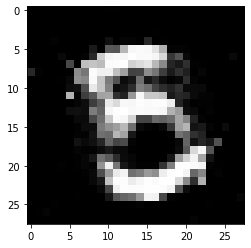

In [15]:
# Detach the image and plot it
x = x.detach()
plt.imshow(x.resize(28,28), cmap='Greys_r')

In [16]:
x.shape

torch.Size([1, 784])

In [17]:
# Define the hyperparametrs
n_iter = 10000

In [18]:
# Define the loss function
mse_loss = torch.nn.MSELoss()

In [19]:
# Get an approximate latent vector
rand_z_approx = torch.from_numpy(np.random.uniform(-1, 1, size=(1, z_size))).float()

In [20]:
# Make sure that gradient is computed
rand_z_approx.requires_grad = True

In [21]:
# Define the Adam optimizer for rand_z_approx. We will use the same lr as used during our training.
import torch.optim as optim

# Optimizers
lr = 0.002
z_optimizer = optim.Adam([rand_z_approx], lr=lr)

In [22]:
# Let's perform stochastic optimization

for i in range(n_iter):
    # get the image in the original space from G
    x_approx = G(rand_z_approx)
    # calculate the mse loss between x_approx and x
    mse_x_approx = mse_loss(x_approx, x)
    mse_z_approx = mse_loss(rand_z_approx, rand_z)
    # print the loss
    if i%100 == 0:
        print("Iteration: {}, MSE for X: {}, MSE for z: {}".format(i, mse_x_approx, mse_z_approx))
    
    # backprop
    z_optimizer.zero_grad()
    if i == n_iter - 1:
        print("OK")
        mse_x_approx.backward()
    else:
        mse_x_approx.backward(retain_graph=True)
    z_optimizer.step()
    
    # stochastic clipping 
    rand_z_approx.data[rand_z_approx.data > 1] = np.random.uniform(-1, 1)
    rand_z_approx.data[rand_z_approx.data < -1] = np.random.uniform(-1, 1)

c:\python37\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 0, MSE for X: 0.38810768723487854, MSE for z: 0.5513102412223816
Iteration: 100, MSE for X: 0.35273778438568115, MSE for z: 0.5543090105056763
Iteration: 200, MSE for X: 0.27675509452819824, MSE for z: 0.5702989101409912
Iteration: 300, MSE for X: 0.26781776547431946, MSE for z: 0.5600307583808899
Iteration: 400, MSE for X: 0.21078816056251526, MSE for z: 0.5211939811706543
Iteration: 500, MSE for X: 0.029873551800847054, MSE for z: 0.45414674282073975
Iteration: 600, MSE for X: 0.005336302798241377, MSE for z: 0.44416818022727966
Iteration: 700, MSE for X: 0.003867138409987092, MSE for z: 0.4402656853199005
Iteration: 800, MSE for X: 0.0030473682563751936, MSE for z: 0.4374006688594818
Iteration: 900, MSE for X: 0.002520038280636072, MSE for z: 0.4351285696029663
Iteration: 1000, MSE for X: 0.0017045863205567002, MSE for z: 0.43265941739082336
Iteration: 1100, MSE for X: 0.001372121972963214, MSE for z: 0.43086352944374084
Iteration: 1200, MSE for X: 0.0011769087286666036, 

c:\python37\lib\site-packages\torch\tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


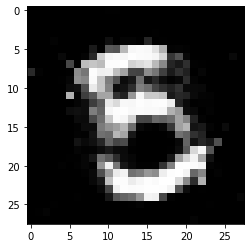

In [23]:
# Plot the approximate image
x_approx = x_approx.detach()
plt.imshow(x_approx.resize(28, 28), cmap='Greys_r')

The approximate image looks very close to the original image `x`

In [24]:
rand_z_approx

tensor([[ 0.3954, -0.1374,  0.3144,  0.4177, -0.6196,  0.7407,  0.6244, -0.2805,
         -0.9495,  0.7258, -0.0913, -0.3866, -0.7088,  0.4084, -0.6774, -0.1919,
         -0.1691,  0.4447, -0.1672, -0.0996,  0.3768,  0.7603,  0.2312, -0.0441,
          0.2570, -0.3462, -0.2492,  0.3277,  0.7547, -0.5177, -0.2348,  0.0833,
         -0.4857, -0.2595,  0.1749, -0.5078, -0.1084,  0.4916,  0.4694, -0.1558,
          0.0628,  0.6467,  0.2641,  0.5632,  0.0379, -0.8628,  0.0752, -0.2442,
         -0.1218,  0.7578,  0.2251,  0.7483,  0.0636,  0.4201, -0.2700,  0.7753,
         -0.2578,  0.2783, -0.0139,  0.1056,  0.9232, -0.3967,  0.6436,  0.8438,
         -0.7652,  0.0821,  0.6674,  0.7456, -0.3214,  0.3515,  0.2495, -0.3160,
         -0.2621, -0.8713,  0.0135,  0.5310,  0.7773, -0.4752,  0.0600, -0.0570,
          0.4357, -0.1368, -0.4554,  0.3397,  0.1791, -0.4269, -0.0215,  0.5480,
         -0.3654, -0.3175,  0.0503, -0.7545,  0.9057,  0.3915,  0.7531,  0.2570,
         -0.4130, -0.4005,  